importing libraries

In [1]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.4/288.4 kB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np
import pandas as pd
import gradio

preprocessing the data

In [4]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_data(data_dir):
  data = []
  for label in labels:
    path = os.path.join(data_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
      try:
        img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        resized_arr = cv2.resize(img_arr, (img_size, img_size))
        data.append([resized_arr, class_num])
      except Exception as e:
          print(e)
  return np.array(data)

In [5]:
train = get_data('/content/drive/MyDrive/chest_xray/train')
test = get_data('/content/drive/MyDrive/chest_xray/test')
val = get_data('/content/drive/MyDrive/chest_xray/val')

<ipython-input-4-9b3231b970d3>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


split x and y labels of training, validation, and testing datasets

In [6]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []


for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in test:
  x_test.append(feature)
  y_test.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

In [7]:
positives = []
negatives = []
for i in range(len(y_train)):
  if y_train[i]:
    positives.append(x_train[i])
  else:
    negatives.append(x_train[i])

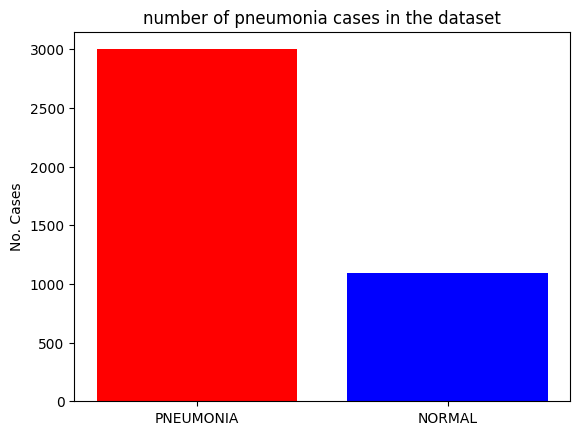

In [8]:
plt.bar(labels, [len(negatives), len(positives)], color = ["red", "blue"])
plt.title("number of pneumonia cases in the dataset")
plt.ylabel("No. Cases")
plt.show()

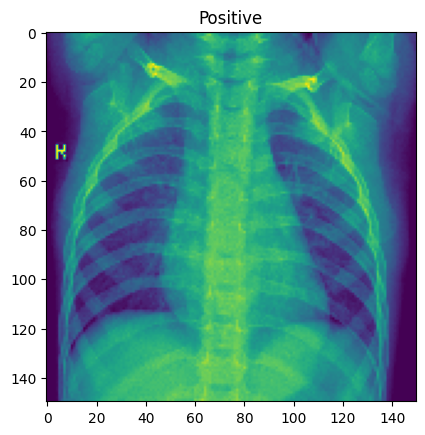

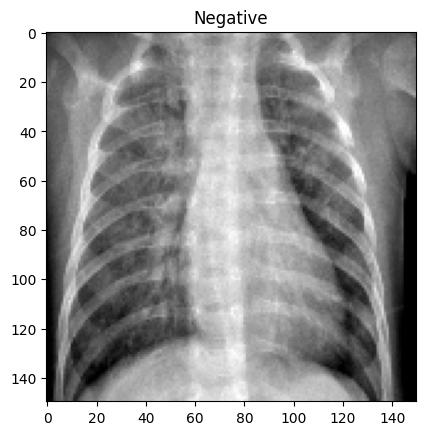

In [9]:
plt.imshow(positives[0])
plt.title("Positive")
plt.show()

plt.imshow(negatives[4], cmap="gray")
plt.title("Negative")
plt.show()


performing a normalization (greyscale) to reduce the effect of illumination's obscurities

In [10]:
x_train = np.array(x_train)/255
x_val = np.array(x_val)/255
x_test = np.array(x_test)/255

resizing the data for CNN training/testing

In [11]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_train.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [12]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_val = y_val.reshape(-1,1)

data augmentation

In [13]:
datagen = ImageDataGenerator (
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range = 30,
    zoom_range = 0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip = True,
    vertical_flip=False)


datagen.fit(x_train)

making the model

In [14]:
model = Sequential()
model.add(Conv2D(32, (3,3), strides=1, padding = 'same', activation = 'relu', input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding = 'same'))

model.add(Conv2D(64, (3,3), strides=1, padding = 'same', activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding = 'same'))

model.add(Conv2D(64, (3,3), strides=1, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding = 'same'))

model.add(Conv2D(128, (3,3), strides=1, padding = 'same', activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding = 'same'))

model.add(Conv2D(256, (3,3), strides=1, padding = 'same', activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = "rmsprop", loss = 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [15]:
model.compile(optimizer = "rmsprop" ,
              loss = 'binary_crossentropy' ,
              metrics = ['accuracy'])

In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy' ,
                                            patience = 2,
                                            verbose = 1,
                                            factor = 0.3,
                                            min_lr = 0.000001)

In [17]:
history = model.fit(datagen.flow(x_train,y_train,batch_size = 32) ,
                    epochs = 10 ,
                    validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = learning_rate_reduction)

Epoch 1/10
128/128 [==============================] - 26s 92ms/step - loss: 0.6157 - accuracy: 0.8379 - val_loss: 25.7575 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
128/128 [==============================] - 11s 86ms/step - loss: 0.2646 - accuracy: 0.8876 - val_loss: 41.1428 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/10
128/128 [==============================] - ETA: 0s - loss: 0.2259 - accuracy: 0.9110
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
128/128 [==============================] - 9s 73ms/step - loss: 0.2259 - accuracy: 0.9110 - val_loss: 37.4704 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/10
128/128 [==============================] - 11s 88ms/step - loss: 0.1534 - accuracy: 0.9484 - val_loss: 11.8715 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/10
128/128 [==============================] - 11s 87ms/step - loss: 0.1313 - accuracy: 0.9506 - val_loss: 0.8298 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 6/10
128/128 [=======================

In [18]:
model.save_weights('/content/drive/MyDrive/models/')

metrics of evaluation

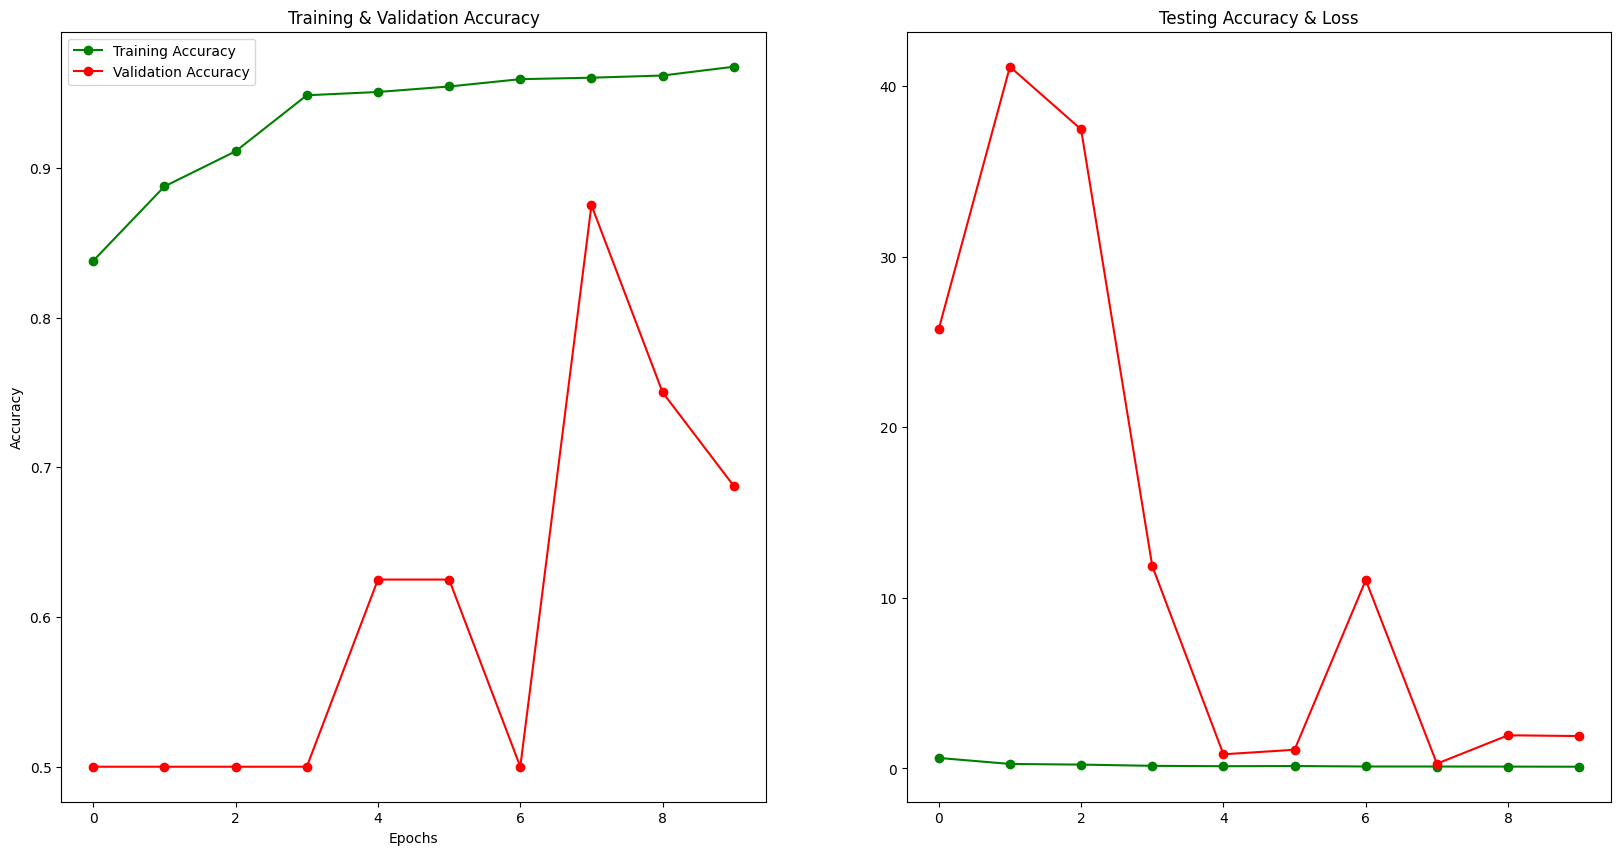

In [19]:
epochs = list(range(10))
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'g-o', label='Training loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Validation loss')
ax[1].set_title('Testing Accuracy & Loss')
plt.show()

In [20]:
predictions = model.predict(x_test)
for i in range(len(predictions)):
  predictions[i] =1 if predictions[i] > 0.5 else 0

128/128 [==============================] - 1s 8ms/step


In [21]:
print(classification_report(y_train, predictions, target_names=['Pneumonia','Normal']))

              precision    recall  f1-score   support

   Pneumonia       1.00      0.88      0.94      3000
      Normal       0.76      0.99      0.86      1091

    accuracy                           0.91      4091
   macro avg       0.88      0.94      0.90      4091
weighted avg       0.93      0.91      0.92      4091



In [22]:
cm = confusion_matrix(y_train,predictions)
cm = pd.DataFrame(cm, index = ['0','1'], columns = ['0','1'])
cm

,0,1
0,2651,349
1,10,1081


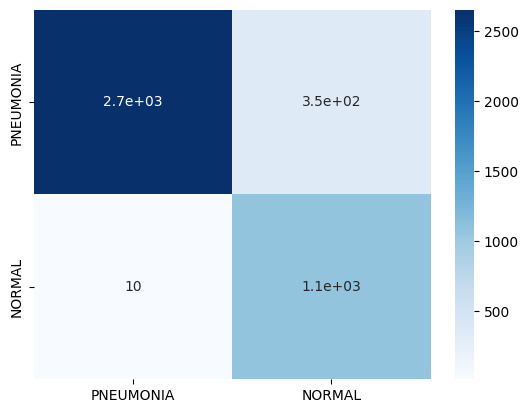

In [23]:
sns.heatmap(cm, cmap="Blues", annot=True, xticklabels=labels, yticklabels=labels)
plt.show()

prediction method

In [24]:
def pneumoniaPrediction(img):
  img = np.array(img)/255
  img = img.reshape(-1, 150, 150, 1)
  isPneumonic = model.predict(img)[0]
  imgClass = "Normal" if isPneumonic < 0.5 else "Pneumonic"
  return imgClass

In [25]:
pr = model.predict(x_test)
for i in range(len(pr)):
  if pr[i]>0.5:
    pr[i]=1
  else:
    pr[i]=0

128/128 [==============================] - 1s 8ms/step


In [26]:
img = gradio.inputs.Image(shape=(150,150))
label = gradio.outputs.Label(num_top_classes=1)

<ipython-input-26-2813547ff8a4>:1: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  img = gradio.inputs.Image(shape=(150,150))
<ipython-input-26-2813547ff8a4>:1: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  img = gradio.inputs.Image(shape=(150,150))
<ipython-input-26-2813547ff8a4>:2: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  label = gradio.outputs.Label(num_top_classes=1)
<ipython-input-26-2813547ff8a4>:2: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  label = gradio.outputs.Label(num_top_classes=1)


In [ ]:
interface = gradio.Interface(fn = pneumoniaPrediction,
                             title = "Pneumonia Detection using X-Ray Image",
                             inputs = img,
                             outputs = label,
                             interpretation = "defalut")
interface.launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://80f4fe431dfb58ee35.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
